<a href="https://colab.research.google.com/github/OptimizationExpert/Pyomo/blob/main/Snake_CP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Developed by Alireza Soroudi
alireza.soroudi@gmail.com

Linkedin News letter : https://www.linkedin.com/newsletters/optimization-in-open-source-6874020019009859585/

Git hub: https://github.com/OptimizationExpert/Pyomo

In [ ]:
import pandas as pd
!pip install ortools
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt # Data visualization
import random
import numpy as np
import time
from google.colab import drive
#drive.mount('/content/drive')


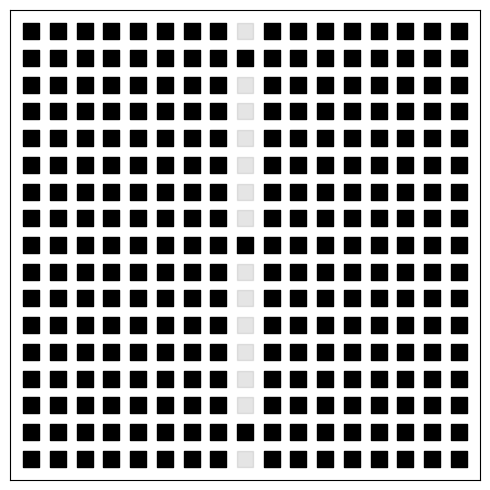

In [ ]:
dic = {}
counter = 0
N = 17
n = N**2

nr, nc = N, N
for r in range(nr):
  for c in range(nc):
    counter+=1
    dic[counter] = (c,r,1)
    if c==(N-1)/2 and r not in [1 , (N-1)/2, N-2]:
      dic[counter] = (c,r,0)


plt.figure(figsize=(5,5))
for counter, (r,c,v) in dic.items():
  plt.scatter(r,c,s=v*120,c='k',marker='s', alpha =1)
  if v==0 :
    plt.scatter(r,c,s=120,c='grey',marker='s', alpha =0.2)

plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.grid()


In [ ]:
def distance(n:int,m:int,data:dict)-> int:
  x1,y1 = data[n][0],data[n][1]
  x2,y2 = data[m][0],data[m][1]
  return int(100*(10000**(2-data[n][2]-data[m][2])) * np.sqrt( (x1-x2)**2+(y1-y2)**2))/100

In [ ]:
distance(4,5,dic), len(dic)

(1.0, 289)

In [ ]:

KOLORS  = ["red", "green", "blue", "orange", "purple", "cyan", "magenta",
    "yellow", "lime", "pink", "brown", "gray", "olive", "navy", "teal"
]
N

17

In [ ]:
def main() -> None:
    # Creates the model.

    model = cp_model.CpModel()

    nodes = [i for i in dic.keys() if dic[i][2]==1]
    x={(i,j):model.NewBoolVar(f"flow_{i}_{j}") for i in nodes for j in nodes if distance(i,j,dic)== 1}
    assign = {i: model.NewBoolVar(f"assign_{i}") for i in nodes}


    endpoint = {i: model.NewBoolVar(f"end_{i}") for i in nodes if dic[i][1] not in [0,N-1] and dic[i][0] not in [0,N-1]}
    startpoint = {i: model.NewBoolVar(f"st_{i}") for i in nodes if dic[i][1] in [0,N-1] or dic[i][0] in [0,N-1]}

    linked= {(i,j): model.NewBoolVar(f"linked_{i}_{j}") for i in startpoint for j in endpoint}


    ###################################################################################################
    arcs= [ (i,j,v) for (i,j),v in x.items()] + [(i,i,assign[i].Not()) for i in nodes] + [(i,j,v) for (i,j),v in linked.items()]
    model.AddCircuit(arcs)

    boundry_nodes_right = [v for i,v in assign.items() if i in startpoint and dic[i][1] >= N/2]
    model.AddExactlyOne(boundry_nodes_right)

    boundry_nodes_all = [v for i,v in assign.items() if i in startpoint]
    model.AddExactlyOne(boundry_nodes_all)


    boundry_nodes = [v for i,v in startpoint.items()]
    model.AddExactlyOne(boundry_nodes)


    nonboundry_nodes = [v for v in endpoint.values()]
    model.AddExactlyOne(nonboundry_nodes)

    nonboundry_nodes_left = [v for i,v in endpoint.items()]
    model.AddExactlyOne(nonboundry_nodes_left)


    for (i,j),v in linked.items():
      model.Add(v <= assign[i])
      model.Add(v <= assign[j])
      model.Add(v >= startpoint[i] + endpoint[j] - 1)
      model.Add(v <= startpoint[i])
      model.Add(v <= endpoint[j])


    ################################### Non Touching ################################################################
    for (i,j),v in x.items():
      if (j,i) in x and i>j:
        model.Add(assign[i]+assign[j]<=  1+ v + x[j,i] )
    ###################################################################################################

    expressions_of = [v for v in assign.values()]
    model.Maximize(cp_model.LinearExpr.Sum(expressions_of))

    solver = cp_model.CpSolver()
    solver.parameters.subsolvers[:] = ['core', 'pseudo_costs', 'no_lp']
    solver.parameters.max_time_in_seconds = 240
    solver.parameters.num_search_workers = 4
    status = solver.solve(model)
    print(solver.StatusName(status))

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        return solver,x, assign, startpoint, endpoint

    else:
        print("No solution found.")


if __name__ == "__main__":
  st= time.time()
  solver, x,assign, startpoint, endpoint = main()
  print("Time ", time.time()-st)
  print(f"Min of objective function: {solver.objective_value}\n")


FEASIBLE
Time  243.34406638145447
Min of objective function: 130.0



In [ ]:
dic[144],dic[145]

((7, 8, 1), (8, 8, 1))

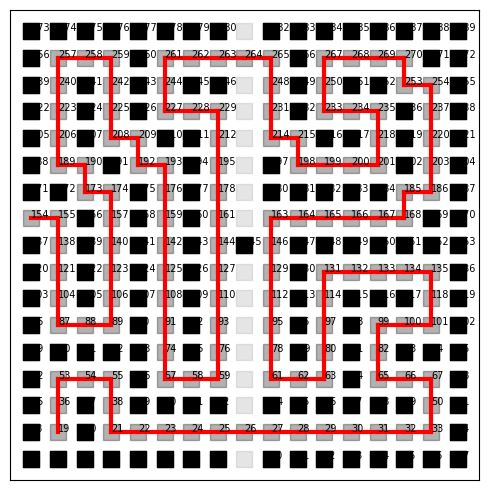

In [ ]:

plt.figure(figsize=(5,5))
for counter, (r,c,v) in dic.items():
  plt.scatter(r,c,s=v*120,c='k',marker='s', alpha =0.3)
  if v==0 :
    plt.scatter(r,c,s=120,c='grey',marker='s', alpha =0.2)

#for counter, (r,c,v) in dic.items():
#  plt.text(r,c,s=str(counter), alpha =0.5)
c=0
for i,v in assign.items():
  r,c = dic[i][0], dic[i][1]
  plt.text(r,c,s=str(i), fontsize=7)

  if solver.value(v) == 0:
    plt.scatter(r,c,s=120,c='k',marker='s', alpha =1)



for (i,j),v in x.items():
  if solver.value(v)>0:
      x1,y1 = dic[i][0],dic[i][1]
      x2,y2 = dic[j][0],dic[j][1]
      plt.plot([x1,x2],[y1,y2], lw=3, c='r', alpha=1,zorder = 2)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.grid()

154 19


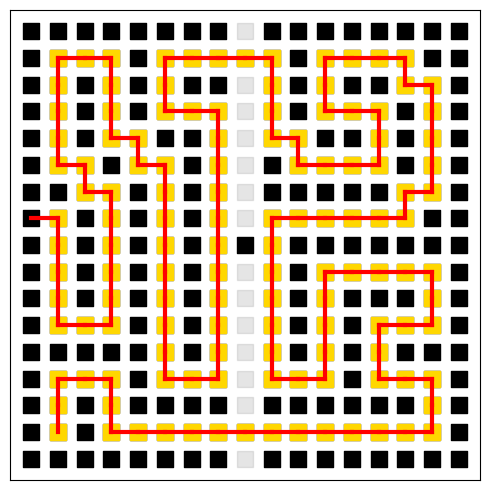

In [ ]:

plt.figure(figsize=(5,5))
for counter, (r,c,v) in dic.items():
  plt.scatter(r,c,s=v*120,c='k',marker='s', alpha =1)
  if v==0 :
    plt.scatter(r,c,s=120,c='grey',marker='s', alpha =0.2)

plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.grid()

st = sum([i*solver.Value(v) for i,v in startpoint.items()])
ep = sum([i*solver.Value(v) for i,v in endpoint.items()])
print(st,ep)
contin = True
counter = 1
while contin:
  for (i,j),v in x.items():
    if solver.Value(v)>0 and j==st:
      x1,y1 = dic[i][0],dic[i][1]
      x2,y2 = dic[j][0],dic[j][1]
      plt.scatter(x1,y1,s=120,c='gold',marker='s', alpha =1, zorder=2)
      plt.plot([x1,x2],[y1,y2], lw=3, c='r', alpha=1,zorder = 2)
      st = i
      #plt.savefig(f'/content/drive/MyDrive/img/graph{counter}.png')
      counter+=1
      if i ==ep:
        contin = False
        break




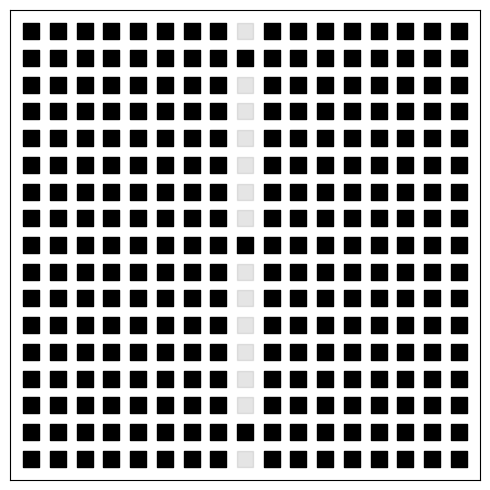

In [ ]:
plt.figure(figsize=(5,5))
for counter, (r,c,v) in dic.items():
  plt.scatter(r,c,s=v*120,c='k',marker='s', alpha =1)
  if v==0 :
    plt.scatter(r,c,s=120,c='grey',marker='s', alpha =0.2)

plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.grid()
